Imports and Set up
===

In [1]:
import pymc3 as pm
import theano.tensor as T
from numpy import random, sum as nsum, concatenate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [4]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

Linear Regression
===

In [5]:
# Set up basic parameters
num_features = 10
num_observed = 1000

In [6]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
X_train = random.normal(size=(num_observed, num_features))

In [7]:
# Calculate the actual data, but put a bit of noise in
y_a = alpha_a + nsum(betas_a[None,:] * X_train, 1) + random.normal(size=(num_observed))

In [8]:
# Set up the PyMC model
lin_reg_model = pm.Model()
with lin_reg_model:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=10.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=10. ** -2, shape=(1, num_features))
    
    # Simulate the noise
    s = pm.HalfNormal(b's', tau=1)
    
    temp = alpha + T.dot(betas, X_train.T)

    y = pm.Normal(b'y', mu=temp , tau=s ** -2, observed=y_a)

Applied log-transform to s and added transformed s_log_ to model.


In [9]:
# Sample from the model
with lin_reg_model:
    step = pm.NUTS()
    nuts_trace = pm.sample(2e3, step)

 [-----------------100%-----------------] 2000 of 2000 complete in 3.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f210d2e5150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f210c85e510>]], dtype=object)

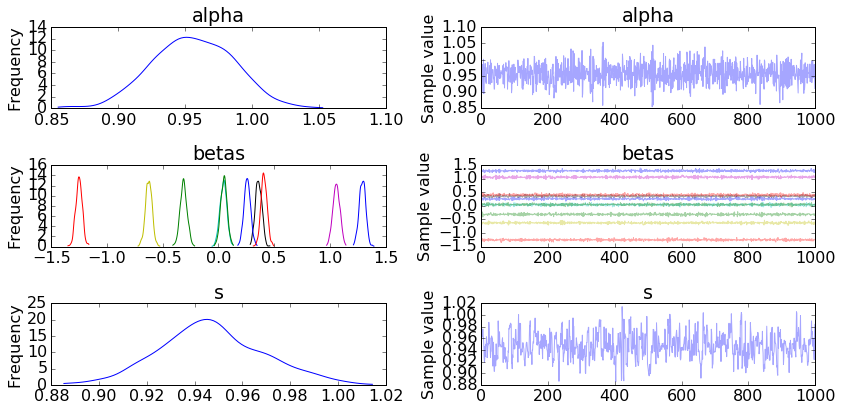

In [10]:
# Plot the trace
# Note: You can specify a burn-in period by indexing appropriately
pm.traceplot(nuts_trace[1000:])

In [11]:
# Look at a summary of the trace
pm.summary(nuts_trace[1000:])


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.956            0.030            0.001            [0.896, 1.010]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.898          0.935          0.956          0.977          1.015


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  1.293            0.029            0.001            [1.237, 1.348]
  -0.313           0.031            0.001            [-0.374, -0.253]
  -1.252           0.029            0.001            [-1.303, -1.192]
  0.044            0.030            0.001            [-0.017, 0.101]
  1.059            0.031            0.001            [0.9

In [12]:
alpha_a

array([ 0.92721228])

In [13]:
betas_a

array([ 1.33947793, -0.32082512, -1.2759568 , -0.01334512,  1.13422414,
       -0.63737931,  0.3401382 ,  0.22348744,  0.07208666,  0.43412935])

Linear Regression: Now with Data!
===

In [14]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

In [15]:
boston = load_boston()

In [16]:
boston_features = pd.DataFrame(boston.data)

In [17]:
boston_features.columns = boston.feature_names

In [18]:
boston_features.CHAS = boston_features.CHAS.astype('bool')

In [19]:
boston_features.RAD = boston_features.RAD.astype('int')

In [20]:
boston_target = pd.DataFrame(boston.target)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    boston_features, boston_target, test_size=0.3)

In [22]:
lr = LinearRegression()

In [23]:
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
lr.score(X_test, Y_test)

0.74246584494396872

In [25]:
X_train.CHAS = X_train.CHAS.astype(int)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [26]:
model_input = theano.shared(np.array(X_train))
model_output = theano.shared(np.array(Y_train))

In [27]:
# Set up the PyMC model
lin_reg_model_w_data = pm.Model()
with lin_reg_model_w_data:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=10.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=10. ** -2, shape=(1, len(X_test.columns)))
    
    # Simulate the noise
    s = pm.HalfNormal(b's', tau=1)
    
    temp = alpha + T.dot(model_input, betas.T)

    y = pm.Normal(b'y', temp , tau=s ** -2, observed=model_output)

Applied log-transform to s and added transformed s_log_ to model.


In [28]:
# Note: If you don't specify a sampler, PyMC3 will choose one for you
with lin_reg_model_w_data:
    nuts_trace = pm.sample(8e3)

Assigned NUTS to alpha
Assigned NUTS to betas
Assigned NUTS to s_log_
 [-----------------100%-----------------] 8000 of 8000 complete in 93.8 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20fab23e50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f20fa1158d0>]], dtype=object)

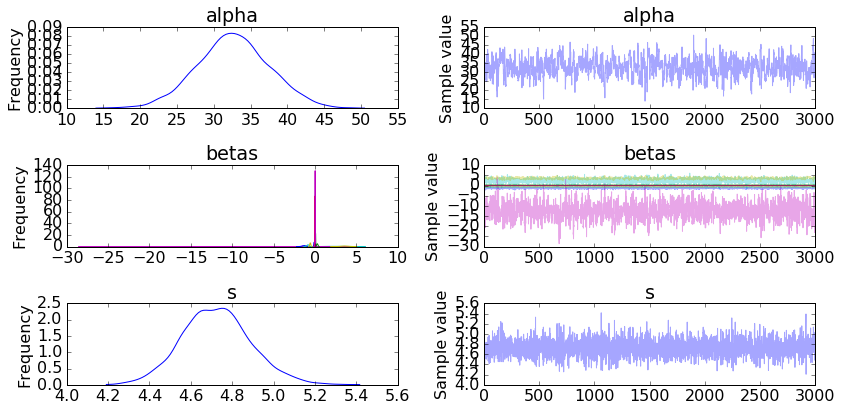

In [29]:
pm.traceplot(nuts_trace[5000:])

In [30]:
pm.summary(nuts_trace[5000:])


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  32.655           4.941            0.199            [22.931, 42.415]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  22.844         29.459         32.670         35.863         42.391


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  -0.105           0.052            0.001            [-0.202, -0.000]
  0.059            0.017            0.000            [0.027, 0.091]
  0.000            0.076            0.001            [-0.157, 0.143]
  2.365            1.052            0.019            [0.273, 4.403]
  -12.348          4.146            0.120            [-2

In [31]:
lr.coef_

array([[ -1.23280645e-01,   5.94370172e-02,   2.05925595e-02,
          2.51276402e+00,  -1.96465128e+01,   2.96311733e+00,
          1.05975400e-02,  -1.52515429e+00,   3.18643102e-01,
         -1.20462421e-02,  -1.03531493e+00,   7.78948459e-03,
         -5.94528054e-01]])

In [32]:
lr.intercept_

array([ 44.98411964])

Now we can score our model
===

In [33]:
X_test.CHAS = X_test.CHAS.astype(int)

In [34]:
# Replace shared variables with testing set
model_input.set_value(np.array(X_test))
model_output.set_value(np.array(Y_test))

In [35]:
# Create posterior predictive samples
ppc = pm.sample_ppc(nuts_trace[1000:], model=lin_reg_model_w_data, samples=1000)

In [36]:
pred = ppc['y'].mean(axis=0)

In [37]:
r2_score(Y_test, pred)

0.75348465523425123

Hiearchical Linear Regression
===

In [38]:
# Set up basic parameters
num_cats = 4
num_per_cat = 50
num_observed = num_per_cat * num_cats
num_features = 3

In [39]:
# Set up markets
cat = concatenate([[i] * num_per_cat for i in range(num_cats)])

# Simulate the features
features = random.normal(size=(num_observed, num_features))

In [40]:
# Choose random values to represent the actual alphas and betas
alpha_a = random.normal(size=(num_cats))
beta_a = random.normal(size=(num_cats, num_features))

In [41]:
# Calculate the actual data, but put a bit of noise in
y = alpha_a[cat] + nsum(beta_a[cat] * features, 1) + random.normal(size=(num_observed))

In [42]:
# Set up the PyMC model
hlm = pm.Model()
with hlm:
    
    # Both alpha and beta are drawn from similar distributions
    mu_alpha = pm.Normal(b"mu_alpha", mu=0, sd=10, shape=(1))
    sigma_alpha = pm.Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = pm.Normal(b"mu_beta", mu=0, sd=10, shape=(1))
    sigma_beta = pm.Uniform(b"sigma_beta", .0, 10, testval=2.)
    
    # Simulate the alphas
    alpha = pm.Normal(b"alpha", mu_alpha, sigma_alpha, shape=(num_cats))
    
    # Simulate the betas
    beta = pm.Normal(b'beta', mu_beta, sigma_beta, shape=(num_cats, num_features))
    
    c = T.constant(cat)
    
    # Simulate the noise
    s = pm.Uniform(b"s", .01, 10, shape=num_cats)

    yd = pm.Normal(b'y', mu=alpha[c] + T.sum(beta[c]*features, 1), tau=s[c] ** -2, observed=y)

    step = pm.NUTS()

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.
Applied interval-transform to s and added transformed s_interval_ to model.


In [43]:
# Actually sample the model, note: you can do this either via the "with" statement 
#or by specifying the model
tr = pm.sample(3e4, step, model=hlm)

 [-----------------100%-----------------] 30000 of 30000 complete in 91.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20b5998ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f20ab98e710>]], dtype=object)

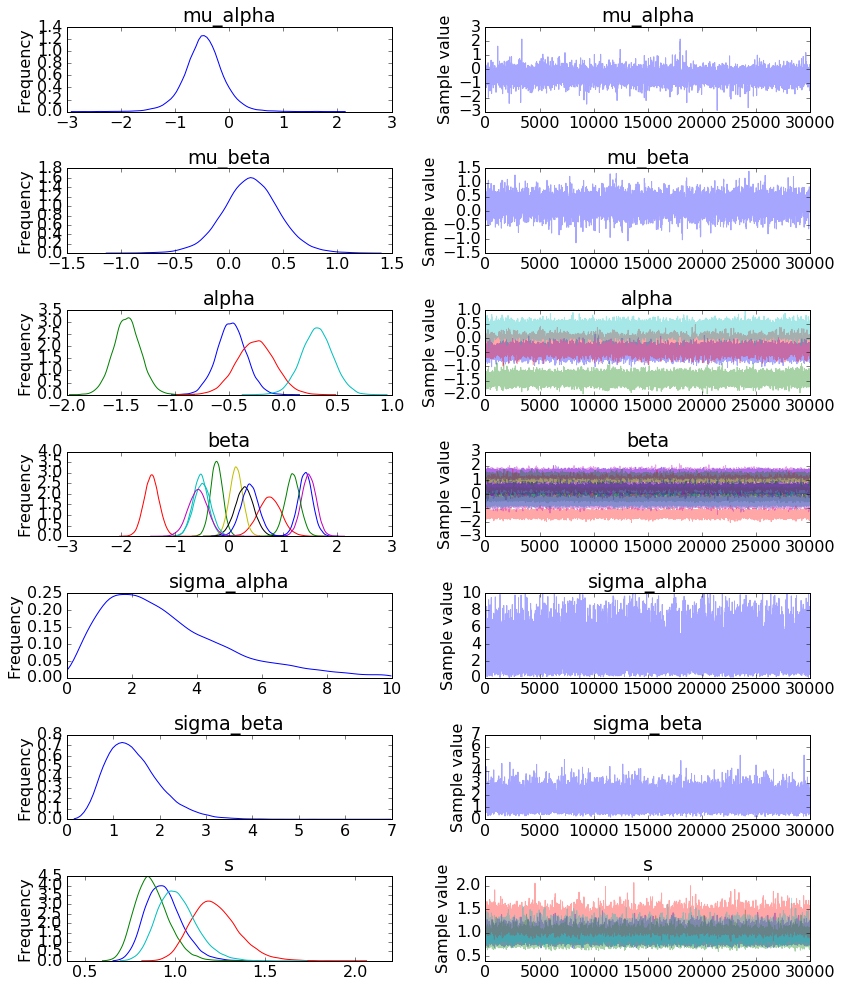

In [44]:
# Plot the variables
pm.traceplot(tr)

In [45]:
# See a summary
pm.summary(tr)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.469           0.376            0.007            [-1.201, 0.284]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.225         -0.686         -0.468         -0.253         0.267


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.202            0.265            0.004            [-0.331, 0.721]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.329         0.034          0.202          0.370          0.727


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

In [46]:
alpha_a

array([-0.580488  , -1.25401058, -0.32916873,  0.30152816])

In [47]:
beta_a

array([[ 1.15572122,  1.49174904,  1.26967198],
       [-0.15481578, -0.03609771, -1.08721447],
       [ 0.46984264,  0.10834049, -0.28137005],
       [-0.29215588,  0.25349541, -0.48157866]])

Logistic Regression
===

In [48]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [49]:
# Set up basic parameters
num_features = 10
num_observed = 1000

In [50]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
X_train = random.normal(size=(num_observed, num_features))
X_test =  random.normal(size=(num_observed, num_features))

In [51]:
# Calculate the outcomes
Y_train = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_train, 1)))
Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_test, 1)))

In [52]:
model_input = theano.shared(X_train)
model_output = theano.shared(Y_train)

In [53]:
log_reg_model = pm.Model()

with log_reg_model:
    alpha = pm.Normal(b'alpha', mu=0, tau=10.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=10. ** -2, shape=(1, num_features))
    
    p = pm.invlogit(alpha + T.sum(betas*model_input, 1))

    o = pm.Bernoulli(b'o', p, observed=model_output)

Let's use ADVI
===

### Note: Make sure there are no NaNs or infinities in your data or you'll get weird results

In [54]:
with log_reg_model:
    v_params = pm.variational.advi(n=10000)

Iteration 0 [0%]: ELBO = -1795.03
Iteration 1000 [10%]: Average ELBO = -1310.93
Iteration 2000 [20%]: Average ELBO = -985.79
Iteration 3000 [30%]: Average ELBO = -742.26
Iteration 4000 [40%]: Average ELBO = -597.14
Iteration 5000 [50%]: Average ELBO = -511.34
Iteration 6000 [60%]: Average ELBO = -459.61
Iteration 7000 [70%]: Average ELBO = -428.28
Iteration 8000 [80%]: Average ELBO = -411.07
Iteration 9000 [90%]: Average ELBO = -401.26
Finished [100%]: Average ELBO = -396.01


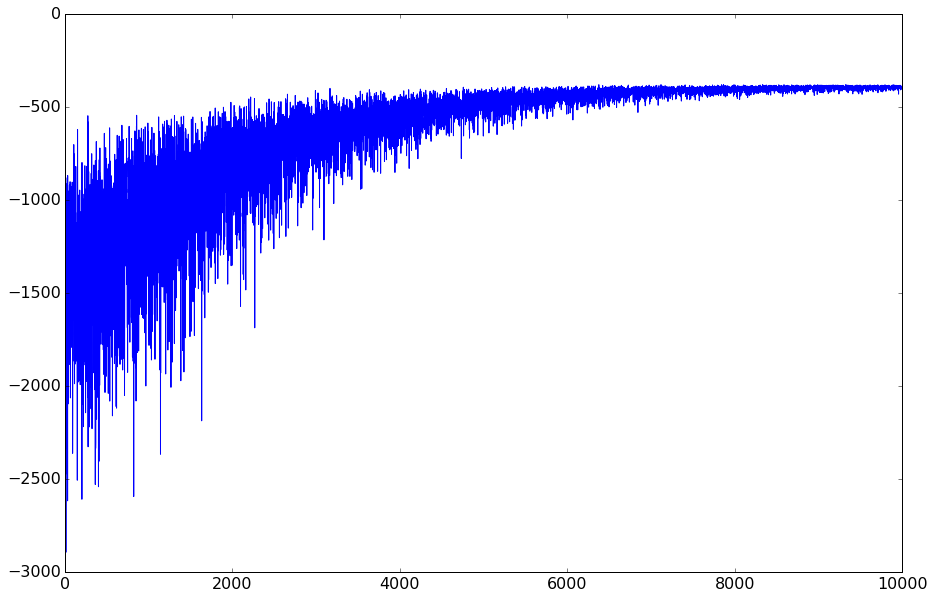

In [55]:
plt.plot(v_params.elbo_vals)

In [56]:
with log_reg_model:
    advi_trace = pm.variational.sample_vp(v_params, draws=5000)

In [57]:
with log_reg_model:
    
    step = pm.NUTS(scaling=v_params.stds)

    nuts_trace = pm.sample(8e3, step, start=v_params.means)


 [-----------------100%-----------------] 8000 of 8000 complete in 27.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f209b922c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f209b7e2810>]], dtype=object)

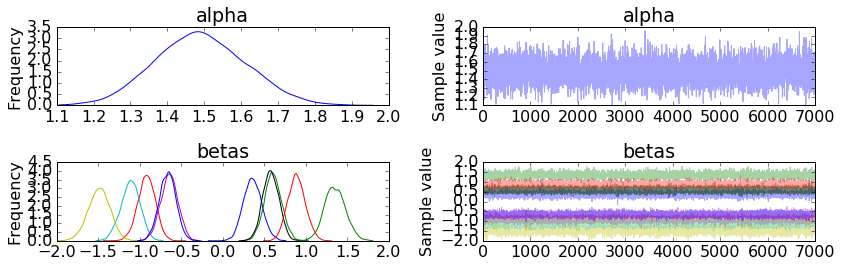

In [58]:
pm.traceplot(nuts_trace[1000:])

In [59]:
pm.summary(nuts_trace[1000:])


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.490            0.123            0.002            [1.243, 1.720]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.256          1.406          1.487          1.572          1.739


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  0.359            0.110            0.001            [0.141, 0.566]
  0.605            0.103            0.001            [0.401, 0.806]
  -0.917           0.105            0.001            [-1.129, -0.715]
  -1.111           0.115            0.002            [-1.339, -0.892]
  -0.643           0.104            0.001            [-0.8

In [60]:
# Replace shared variables with testing set
model_input.set_value(X_test)
model_output.set_value(Y_test)

In [61]:
# Create posterior predictive samples from ADVI
ppc = pm.sample_ppc(advi_trace, model=log_reg_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [62]:
print('ADVI Accuracy = {}%'.format((Y_test == pred).mean() * 100))

ADVI Accuracy = 85.2%


In [63]:
# Create posterior predictive samples from NUTS
ppc = pm.sample_ppc(nuts_trace[1000:], model=log_reg_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [64]:
print('NUTS Accuracy = {}%'.format((Y_test == pred).mean() * 100))

NUTS Accuracy = 85.2%


API-ify your model
===

In [65]:
# First, create some test data
API_test =  random.normal(size=(1, num_features))

In [66]:
API_Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * API_test, 1)))

In [67]:
API_Y_test

1

In [68]:
# Put in some fake data
API_fake_Y = 0

In [69]:
model_input = theano.shared(API_test)

In [70]:
API_model = pm.Model()

with API_model:
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    #p = invlogit(alpha+T.dot(predictors, betas))
    p = pm.invlogit(alpha + T.sum(betas*model_input, 1))

    #o = Bernoulli(b'o', p, shape=(1, 2))
    o = pm.Bernoulli(b'o', p, observed=API_fake_Y)

In [71]:
# Create posterior predictive samples
ppc = pm.sample_ppc(advi_trace, model=API_model, samples=1000)

In [72]:
# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [73]:
pred

array([ True], dtype=bool)

Hiearchical Logistic Regression
===

In [74]:
# Set up basic parameters
num_cats = 4

# Need lots of data to converge
num_per_cat = 15000
num_observed = num_per_cat * num_cats
num_features = 100

In [75]:
# Set up markets
cat = concatenate([[i] * num_per_cat for i in range(num_cats)])

In [76]:
# Simulate the features
features = np.random.normal(size=(num_observed, num_features))

In [77]:
alpha_a = np.random.normal(size=(num_cats))
beta_a = np.random.normal(size=(num_cats, num_features))

In [78]:
# Calculate the actual data
p = alpha_a[cat] + nsum(beta_a[cat] * features, 1)

In [79]:
outcomes = np.random.binomial(1, numpy_invlogit(p))

In [80]:
hlr = pm.Model()

with hlr:
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = pm.Normal(b"mu_alpha", mu=0, sd=10, shape=(1))
    sigma_alpha = pm.Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = pm.Normal(b"mu_beta", mu=0, sd=10, shape=(1))
    sigma_beta = pm.Uniform(b"sigma_beta", 0, 10, testval=2.)
    
    alpha = pm.Normal(b'alpha', mu=mu_alpha, tau=sigma_alpha, shape=(num_cats))
    beta = pm.Normal(b'beta', mu=mu_beta, tau=sigma_beta, shape=(num_cats, num_features))
    
    c = T.constant(cat)

    p = pm.invlogit(alpha[c] + T.sum(beta[c]*features, 1))
    
    o = pm.Bernoulli(b'o', p, observed=outcomes)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.


In [81]:
with hlr:
    v_params = pm.variational.advi(n=10000)

Iteration 0 [0%]: ELBO = -225913.81
Iteration 1000 [10%]: Average ELBO = -214118.93
Iteration 2000 [20%]: Average ELBO = -166096.97
Iteration 3000 [30%]: Average ELBO = -134552.33
Iteration 4000 [40%]: Average ELBO = -116137.25
Iteration 5000 [50%]: Average ELBO = -105315.09
Iteration 6000 [60%]: Average ELBO = -97074.78
Iteration 7000 [70%]: Average ELBO = -79232.97
Iteration 8000 [80%]: Average ELBO = -53199.38
Iteration 9000 [90%]: Average ELBO = -34891.84
Finished [100%]: Average ELBO = -24141.69


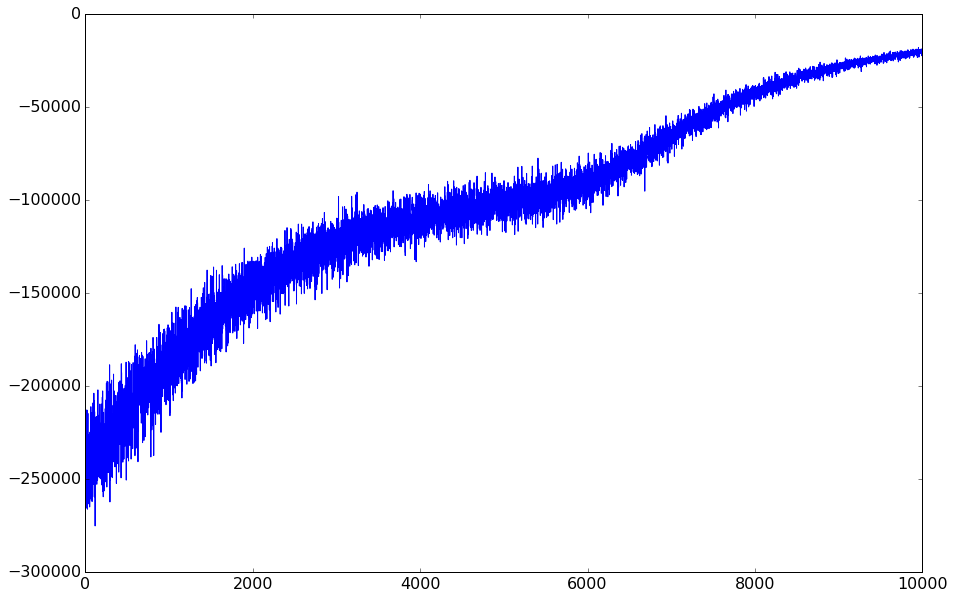

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
with hlr:
    
    step = pm.NUTS(scaling=v_params.stds)
    trace = pm.sample(20000, step, start=v_params.means)

 [-                 4%                  ] 955 of 20000 complete in 3719.5 sec

### Note: You can stop your trace part way through and still use it!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f201190ee10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f200d6fc290>]], dtype=object)

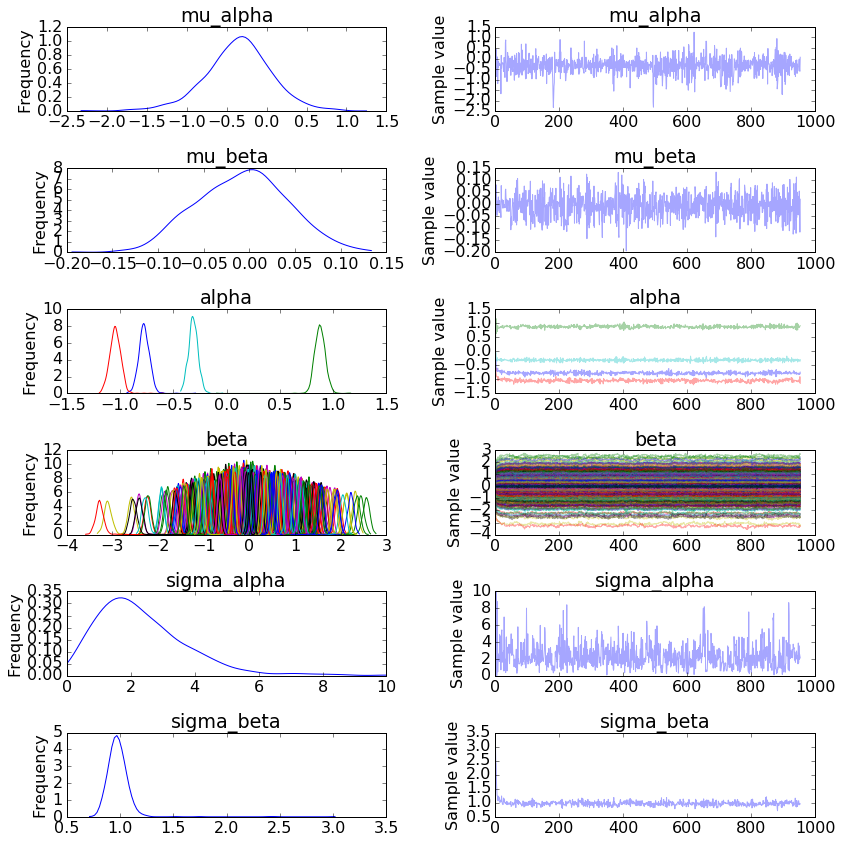

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.354           0.430            0.015            [-1.227, 0.508]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.291         -0.598         -0.332         -0.094         0.477


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.007           0.049            0.002            [-0.098, 0.089]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.101         -0.043         -0.006         0.026          0.087


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

In [ ]:
beta_a

array([[  1.42650920e+00,  -9.28040472e-01,   1.34002755e+00,
          9.98738545e-01,  -3.06923456e-01,  -1.35824772e+00,
          6.31466132e-02,  -1.33778460e+00,  -6.56459552e-01,
         -2.19262671e-01,   1.46069704e+00,   1.90985840e+00,
          1.22563806e+00,  -5.52129258e-01,  -8.93950292e-01,
          1.82922078e+00,   2.70245308e-01,  -4.10748280e-01,
         -5.23941602e-01,  -2.98421769e-01,   3.56507040e-01,
         -2.04082940e-01,   6.19009825e-01,  -1.85603962e+00,
         -9.20547360e-01,   1.26815506e-01,   1.51976160e+00,
         -6.25370317e-01,  -1.51927029e+00,  -4.23262247e-01,
         -6.26661546e-01,   2.24772976e+00,  -2.19736542e+00,
         -7.10227668e-01,  -4.11809543e-01,  -2.89405349e-02,
          1.79590931e+00,  -1.21629449e+00,  -1.46973595e+00,
         -1.90680762e-01,  -7.80363268e-01,  -6.58174425e-01,
         -1.55398746e-01,  -1.73969946e-01,   3.34979472e-01,
          1.84464014e-01,   7.11269979e-01,   7.17037359e-01,
        

In [ ]:
alpha_a

array([-0.78721431,  0.86955852, -1.00957388, -0.27053796])

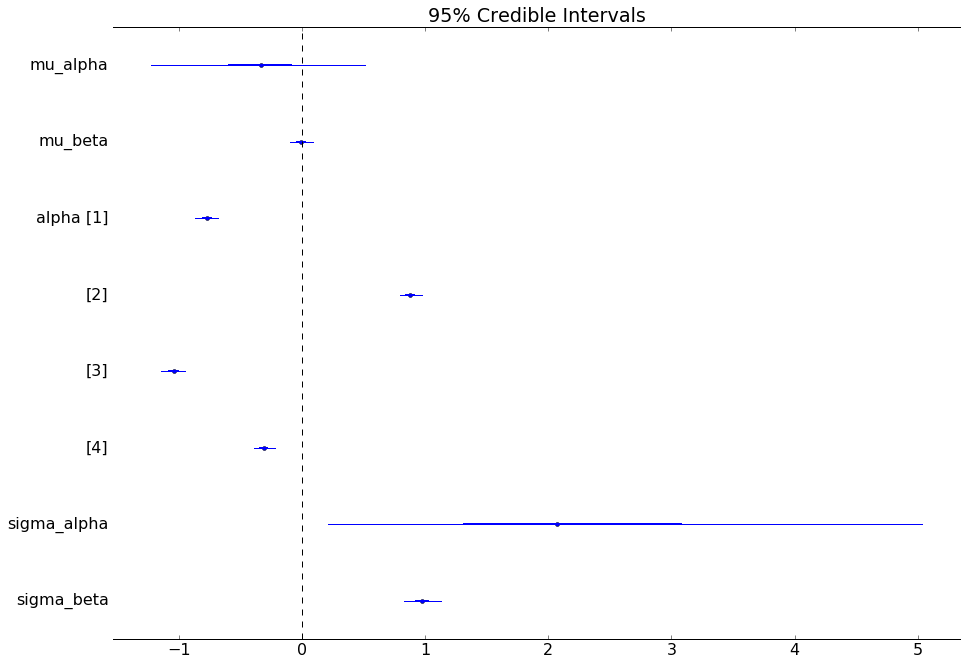

In [ ]:
pm.forestplot(trace, varnames=['mu_alpha', 'mu_beta', 'alpha', 'sigma_alpha', 'sigma_beta'])